In [31]:
import pandas as pd
import numpy as np
import geopandas as gpd
import networkx as nx
import fiona
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
five_kcs_path = "D:\\DBMSP\\Dataset\\5KCS\\5KCS.zip"
five_kcs = gpd.read_file(five_kcs_path)


In [19]:
sindex = five_kcs.sindex
G = nx.Graph()

In [20]:
#Preprocessing Step - 1
for i, geometry in five_kcs.geometry.items():
    possible_neighbors = list(sindex.intersection(geometry.bounds))
    for j in possible_neighbors:
        if i != j and five_kcs.geometry.iloc[i].touches(five_kcs.geometry.iloc[j]):
            G.add_edge(i, j)

In [6]:
import json
import networkx as nx


def save_graph_to_json(G, file_path):
    graph_json = nx.readwrite.json_graph.adjacency_data(G)
    with open(file_path, 'w') as f:
        json.dump(graph_json, f)


def save_graph_to_txt(G, file_path):
    with open(file_path, 'w') as f:
        for edge in G.edges():
            f.write(f"{edge[0]} {edge[1]}\n")

txt_file_path = "D:\\DBMSP\\Dataset\\2KCT\\2KCT_graph.txt"
save_graph_to_txt(G, txt_file_path)


In [22]:
#Preprocessing step - 2
degree_list = {}
# Iterating over each to find if enclosed
for parent_index, parent_area in five_kcs.iterrows():
    nested_areas = five_kcs[five_kcs.within(parent_area['geometry'])]
    degree = len(nested_areas) - 1  
    if degree > 0:
        degree_list[parent_index] = degree

In [23]:
#Growing Phase
import random


Au = set(five_kcs.index)  
Aa = set()

cardinalities = [100,200, 300, 400]
regions = {i: set() for i in range(len(cardinalities))}  

def get_unassigned_neighbors(region, graph, assigned):
    unassigned_neighbors = set()
    for node in region:
        for neighbor in graph.neighbors(node):
            if neighbor not in assigned:
                unassigned_neighbors.add(neighbor)
    return list(unassigned_neighbors)

max_retries = 100
unassigned_neighbors = [] 

for i, cardinality in enumerate(cardinalities):
    retries = 0
    while retries < max_retries:
       
        if i == 0 or not unassigned_neighbors:
            if not Au:  
                print("No unassigned areas left to form a region.")
                break
            seed = random.choice(list(Au))
        else: 
            unassigned_neighbors = get_unassigned_neighbors(regions[i-1], G, Aa)
            seed = random.choice(unassigned_neighbors) if unassigned_neighbors else None

        if not seed:
            retries += 1
            continue

        regions[i] = {seed}
        Aa.add(seed)
        Au.remove(seed)

        SNr = get_unassigned_neighbors({seed}, G, Aa)
        while len(regions[i]) < cardinality and SNr:
            ai = random.choice(SNr)
            regions[i].add(ai)
            Aa.add(ai)
            Au.remove(ai)
            SNr.remove(ai)
            SNr.extend(get_unassigned_neighbors({ai}, G, Aa))
            SNr = list(set(SNr))  

        if len(regions[i]) >= cardinality:
            break
        else:
           
            for area in regions[i]:
                Au.add(area)
                Aa.discard(area)
            regions[i].clear()
            retries += 1

    if retries == max_retries:
        print(f"Max retries reached for region {i}. Unable to satisfy the cardinality constraint.")

five_kcs['region'] = -1  
for region_index, areas in regions.items():
    for area_index in areas:
        five_kcs.loc[area_index, 'region'] = region_index


In [24]:
unique_regions = five_kcs['region'].unique()
n_regions = len(unique_regions)
print(n_regions)

5


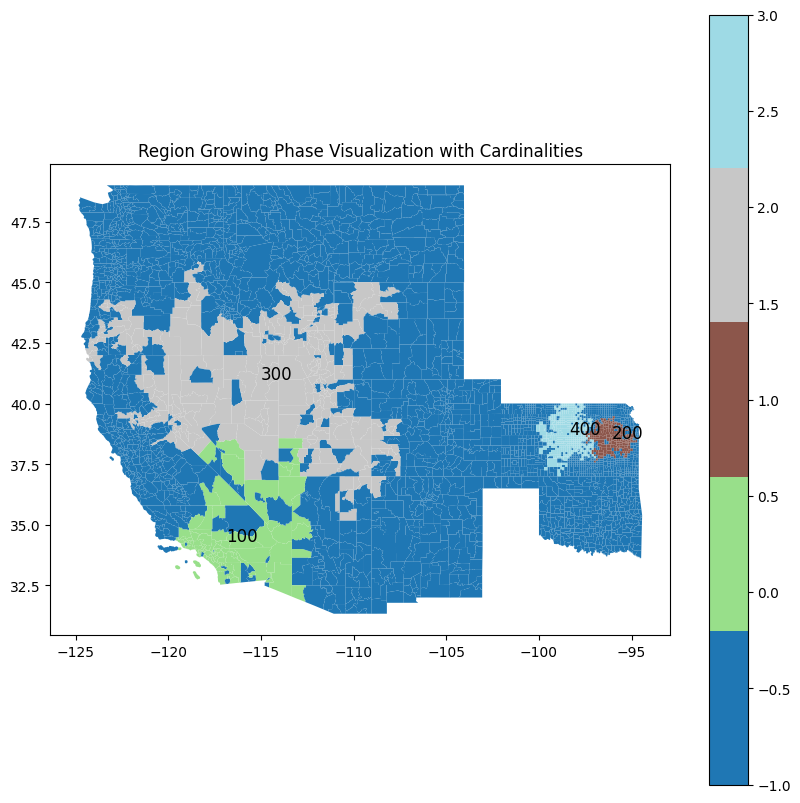

In [27]:
def get_avg_coords(region_indices, gdf):
    x_coords = []
    y_coords = []
    for idx in region_indices:
        x, y = gdf.loc[idx].geometry.centroid.xy
        x_coords.append(x[0])
        y_coords.append(y[0])
    return np.mean(x_coords), np.mean(y_coords)

five_kcs['region'] = -1  
for region_index, areas in regions.items():
    for area_index in areas:
        five_kcs.loc[area_index, 'region'] = region_index

unique_regions = five_kcs['region'].unique()
n_regions = len(unique_regions)

cmap = plt.get_cmap('tab20', n_regions)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
five_kcs.plot(column='region', ax=ax, cmap=cmap, legend=True)

for region, cardinality in enumerate(cardinalities):
    avg_x, avg_y = get_avg_coords(regions[region], five_kcs)
    ax.text(avg_x, avg_y, str(cardinality), color='black', fontsize=12)

plt.title('Region Growing Phase Visualization with Cardinalities')

plt.show()

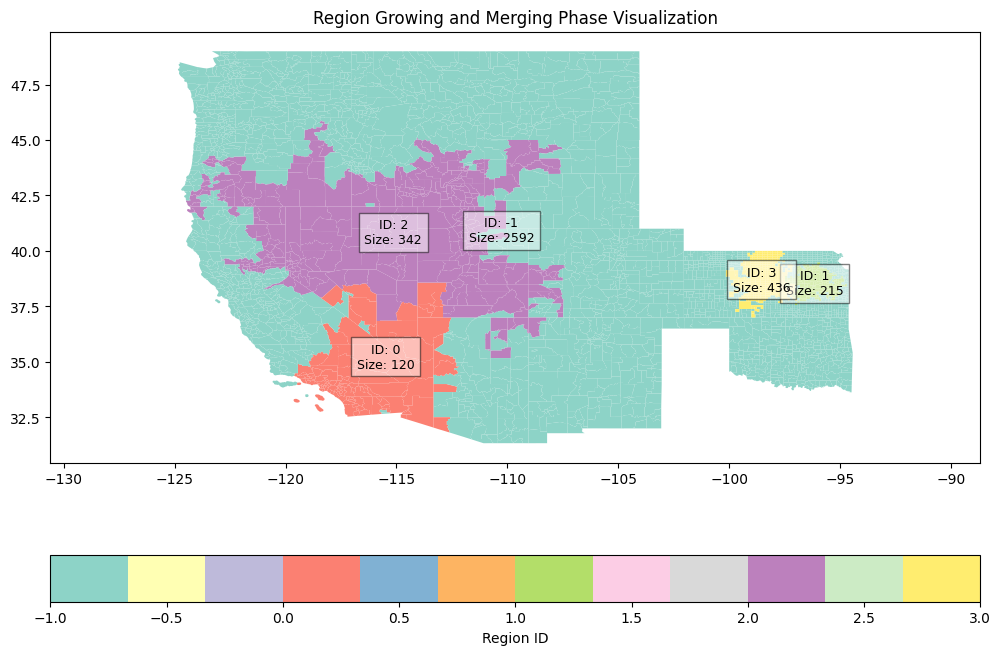

In [30]:
import networkx as nx
import matplotlib.pyplot as plt


def merge_disconnected_components(G, five_kcs, Au, Aa):
    components = list(nx.connected_components(G.subgraph(Au)))
    if len(components) > 1:
        components.sort(key=len, reverse=True)
        largest_component = components[0]
        for component in components[1:]:
            for area in component:
                neighboring_regions = five_kcs.loc[list(G.neighbors(area))]['region']
                most_common_region = neighboring_regions.mode()[0]
                if pd.notna(most_common_region):
                    five_kcs.at[area, 'region'] = most_common_region
                    five_kcs.at[area, 'merged'] = True
                    Aa.add(area)
                    Au.remove(area)
                    
five_kcs['merged'] = False

                    
merge_disconnected_components(G, five_kcs, Au, Aa)

fig, ax = plt.subplots(figsize=(12, 8))

five_kcs.plot(column='region', ax=ax, cmap='Set3', legend=True, 
              legend_kwds={'label': "Region ID", 'orientation': "horizontal"})


for region_id, group in five_kcs.groupby('region'):
    centroid = group.geometry.unary_union.centroid
    size = group.shape[0]
    ax.text(centroid.x, centroid.y, f'ID: {region_id}\nSize: {size}', 
            ha='center', va='center', fontsize=9, bbox=dict(facecolor='white', alpha=0.5))

ax.set_title("Region Growing and Merging Phase Visualization")
plt.axis('equal')
plt.show()

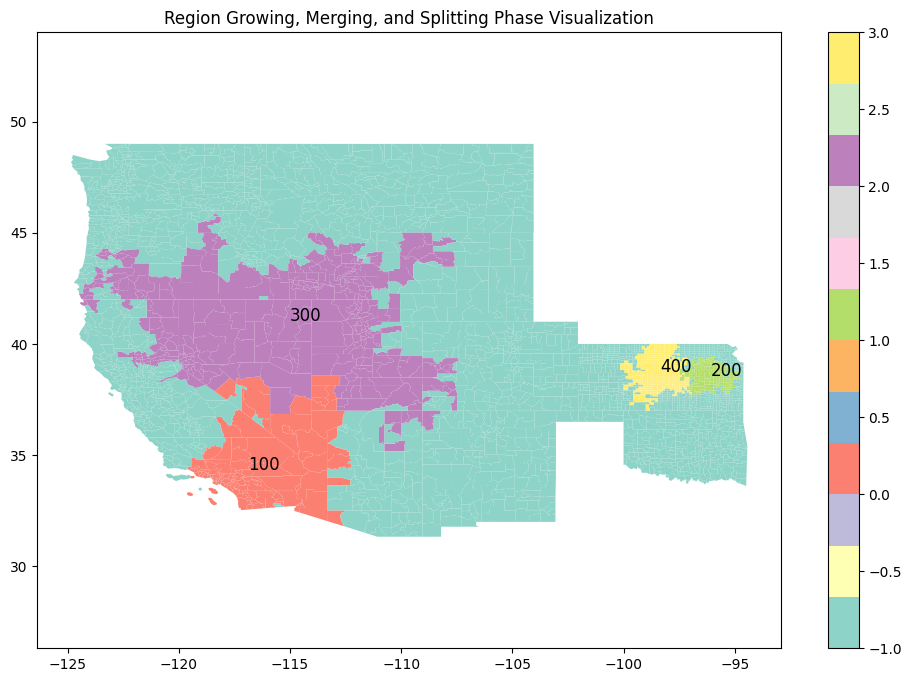

In [29]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np


def identify_removal_candidates(region, G, Aa):
    candidates = []
    for area in region:
        if area not in Aa: 
            continue
        neighbors = set(G.neighbors(area))
        if neighbors.issubset(region): 
            candidates.append(area)
    return candidates

def split_region(regions, region_id, target_cardinality, G, Aa):
    excess = len(regions[region_id]) - target_cardinality
    while excess > 0:
        removal_candidates = identify_removal_candidates(regions[region_id], G, Aa)
        if not removal_candidates:
            raise ValueError(f"No candidates for removal found for region {region_id}")
        for _ in range(excess):
            area_to_remove = removal_candidates.pop()
            regions[region_id].remove(area_to_remove)
            Aa.remove(area_to_remove)
            excess -= 1
    return regions

for region_id, cardinality in enumerate(cardinalities):
    if len(regions[region_id]) > cardinality:
        regions = split_region(regions, region_id, cardinality, G, Aa)

for region_index, areas in regions.items():
    for area_index in areas:
        five_kcs.at[area_index, 'region'] = region_index

fig, ax = plt.subplots(figsize=(12, 8))
five_kcs.plot(column='region', ax=ax, cmap='Set3', legend=True)
ax.set_title("Region Growing, Merging, and Splitting Phase Visualization")

def annotate_regions(regions, ax):
    for region_index, areas in regions.items():
        region_centroid = np.mean([five_kcs.geometry.loc[area].centroid.coords[0] for area in areas], axis=0)
        ax.annotate(str(len(areas)), (region_centroid[0], region_centroid[1]), color='black', fontsize=12)

annotate_regions(regions, ax)

plt.axis('equal')
plt.show()
